In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import fiona

# set working directory
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_3994/3426520483.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
flowlines = pd.read_excel('FlowlineSpreadsheet_Mines.xlsx')
spills = pd.read_excel('Flowline-Related Spills (2022).xlsx')

In [3]:
print(flowlines.info())
print(flowlines.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21942 entries, 0 to 21941
Data columns (total 88 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DOC_NUM               21942 non-null  int64  
 1   FORM_NUM              21942 non-null  int64  
 2   RECEIVE_DATE          21942 non-null  object 
 3   OPERATOR_NUM          21942 non-null  int64  
 4   COMPANY_NAME          21942 non-null  object 
 5   SUBMIT_DATE           21942 non-null  object 
 6   STATUS_DATE           21942 non-null  object 
 7   FACILITY_ID           591 non-null    float64
 8   STATUS                21942 non-null  object 
 9   USER_NAME             21942 non-null  object 
 10  DATA_ENTRY_DATE       21942 non-null  object 
 11  DATA_ENTRY_OP         21867 non-null  object 
 12  LOCATION_ID           21928 non-null  float64
 13  LAST_USER             21942 non-null  object 
 14  LAST_UPDATE_USER      21942 non-null  object 
 15  LAST_UPDATE_DATE   

In [4]:
print(spills.info())
print(spills.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trkg_num                  1726 non-null   int64  
 1   Operator Name             1726 non-null   object 
 2   operator_num              1726 non-null   object 
 3   incident_date             1726 non-null   object 
 4   facility_type             1675 non-null   object 
 5   Spill_Desc                1726 non-null   object 
 6   county                    1726 non-null   object 
 7   Spill Type                880 non-null    object 
 8   Root Cause                1005 non-null   object 
 9   Preventative Measure      971 non-null    object 
 10  Root Cause Type           1726 non-null   object 
 11  Detailed Root Cause Type  1581 non-null   object 
 12  Long                      1537 non-null   float64
 13  Lat                       1537 non-null   float64
 14  oil_spil

Check to see if the DOC_NUM and trkg_num are the same
- results in empty set so there are disjoint

In [5]:
flowlines_id = set(flowlines.DOC_NUM)
spills_id= set(spills.trkg_num)
flowlines_id.intersection(spills_id)

set()

Count how many of points are within the rectangles


In [6]:
flowlines_lat = flowlines.LAT
flowlines_lat.describe()

count    21940.000000
mean        40.033706
std          0.739438
min         37.010427
25%         40.026688
50%         40.185580
75%         40.367810
max         40.993496
Name: LAT, dtype: float64

In [7]:
spills_lat = spills.Lat.dropna()
spills_lat.describe()

count    1537.000000
mean       18.566716
std        51.290513
min      -108.954300
25%        37.264610
50%        39.993190
75%        40.269967
max        40.997350
Name: Lat, dtype: float64

<Axes: >

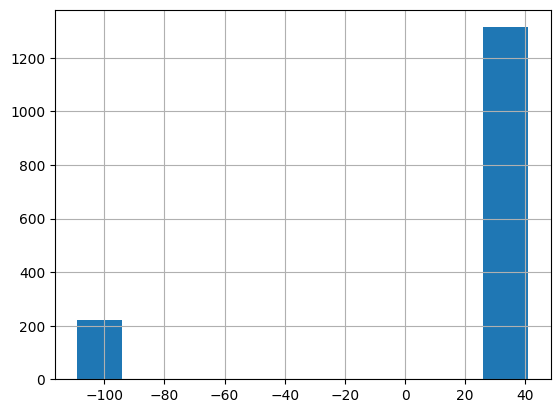

In [8]:
spills_lat.hist()

In [9]:
set(flowlines_lat).intersection(set(spills_lat))

{37.08071,
 39.257664,
 39.54742,
 39.803342,
 39.868538,
 39.87647,
 39.959898,
 39.97735,
 39.99131,
 39.995911,
 40.02917,
 40.0943,
 40.098741,
 40.105189,
 40.1205,
 40.1243,
 40.132563,
 40.13928,
 40.19165,
 40.25225,
 40.407008,
 40.4369,
 40.451472,
 40.493504,
 40.529683,
 40.56804,
 40.643635,
 40.855199,
 40.95103}

<Axes: >

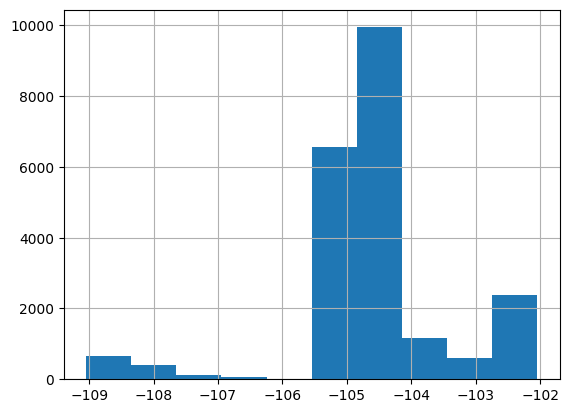

In [10]:
flowlines.LONG.hist()

Find which spills belong to each flowline
- e, eplison factor. currnetly it is at zero


In [11]:
def in_rectangle(flowlines, spills, e=0):
    assert len(flowlines) == 4
    assert len(spills) == 2
    [lat, long] = spills
    [lat_start, lat_end, long_start, long_end] = flowlines
    return ( lat_start -e <= lat <= lat_end + e) and (long_start -e <= long <= long_end + e)


TEST

In [12]:
tests = [
    in_rectangle([-1, 1, -1, 1], [0,0]),
    not in_rectangle([-1, 1, -1, 1], [-1.01,0], e=0.0),
    in_rectangle([-1, 1, -1, 1], [-1.01,0], e=0.1),
    not in_rectangle([-1, 1, -1, 1], [-2,0]),
    not in_rectangle([-1, 1, -1, 1], [-2,0], e=0.002),
]
print(tests)
assert all(tests)

[True, True, True, True, True]


implement test to data

In [13]:
line_lat_start = list(flowlines.STARTLAT.values)
line_lat_end = list(flowlines.ENDLAT.values)
line_long_start = list(flowlines.STARTLONG.values)
line_long_end = list(flowlines.ENDLONG.values)
line_index = list(flowlines.index)

spill_lat = list(spills.Lat.values)
spill_long = list(spills.Long.values)
spill_idx = list(spills.index)

match_ids = dict()

In [14]:
# TODO : change to find closest rectangle
for flowlines_id, line in zip(line_index, zip(line_lat_start, line_lat_end, line_long_start, line_long_end)):
    for spills_id, spill in zip(spill_idx, zip(spill_lat, spill_long)):

        if any([np.isnan(e) for e in line]):
            continue

        if in_rectangle(flowlines=line, spills=spill):
            match_ids[flowlines_id] = spills_id

print(match_ids)

{755: 268, 905: 1187, 981: 358, 982: 358, 1483: 12, 2033: 840, 2113: 885, 2300: 857, 2308: 244, 2309: 244, 2311: 244, 2312: 244, 2314: 244, 2318: 244, 2375: 1027, 2551: 885, 2589: 12, 2726: 518, 2727: 518, 2808: 12, 2903: 12, 3190: 885, 3201: 885, 3205: 885, 3747: 464, 3932: 1509, 4324: 1025, 4325: 1025, 4855: 1187, 4862: 1187, 5008: 1148, 5094: 1195, 5097: 1195, 5105: 1649, 5199: 1227, 5639: 395, 5805: 1629, 5806: 1629, 5878: 518, 5880: 518, 5943: 1540, 6001: 264, 6002: 264, 6468: 702, 6670: 1589, 6910: 518, 6911: 518, 7025: 264, 7026: 264, 8724: 1148, 8779: 1195, 8780: 1195, 8879: 1649, 9010: 395, 9129: 1227, 9168: 734, 9172: 984, 9268: 738, 9345: 5, 9347: 5, 9351: 735, 9353: 5, 9354: 5, 9358: 5, 9363: 735, 9364: 735, 9370: 5, 9375: 5, 9379: 5, 9382: 5, 9386: 5, 9388: 735, 9390: 5, 9392: 5, 9393: 5, 9396: 5, 9397: 5, 9399: 5, 9503: 362, 9512: 347, 9536: 266, 9546: 738, 9549: 738, 9557: 266, 9562: 266, 9570: 266, 9573: 266, 9580: 738, 9595: 266, 9597: 266, 9611: 738, 9706: 735, 9712: 

In [15]:
def test():
    (line, spill) = 2551, match_ids[2551]
    flowlines_record = flowlines.loc[line] 
    # rect_record.START_LAT
    flowlines_list = [
        flowlines_record.STARTLAT,
        flowlines_record.ENDLAT,
        flowlines_record.STARTLONG,
        flowlines_record.ENDLONG
    ]

    spills_record = spills.loc[spill]
    
    spills_list = [
        spills_record.Lat,
        spills_record.Long
    ]
    print(flowlines_list, spills_list)
    return in_rectangle(flowlines=flowlines_list, spills=spills_list)

test()

[40.612404, 40.616101, -104.834939, -104.824284] [40.6157, -104.83062]


True

In [16]:
# flowine to spill
flowlines_id_to_spills_id = match_ids

join_col = flowlines.index.map(lambda x: flowlines_id_to_spills_id.get(x) or np.nan)

pd.Series(join_col).describe()

flowlines['join_col'] = join_col 
spills['join_col'] = spills.index

In [17]:
merged = pd.merge(flowlines, spills, how='inner', on="join_col", copy=True)

In [18]:
merged.to_excel("flowlines_to_spills.xlsx")


In [19]:
flowlines_to_spills = pd.read_excel('flowlines_to_spills.xlsx')


In [20]:
flowlines_to_spills

,Unnamed: 0,DOC_NUM,FORM_NUM,RECEIVE_DATE,OPERATOR_NUM,COMPANY_NAME,SUBMIT_DATE,STATUS_DATE,FACILITY_ID,STATUS,...,other_recovered,other_spilled_specify,facility_status,Basin,Gathering?,Metallic?,Unnamed: 121,nan.1,On Location?,Fac or Loc ID
0,0,403429524,44,2023-06-09 15:35:41.937,74165,RENEGADE OIL & GAS COMPANY LLC ...,2023-06-09 15:35:41.937,2023-06-20 11:03:15.7,NaN,APPROVED,...,NaN,0.0,CL,DENVER JULESBURG BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN
1,1,403363799,44,2023-04-19 16:09:48.24,46290,KP KAUFFMAN COMPANY INC ...,2023-04-19 16:09:48.24,2023-05-09 11:21:01.897,NaN,APPROVED,...,0.0,NaN,NaN,Denver (DJ) Basin,NaN,NaN,,,NaN,NaN
2,2,403126512,44,2022-08-04 10:27:50.017,74165,RENEGADE OIL & GAS COMPANY LLC ...,2022-08-04 10:27:50.017,2023-03-21 13:24:17.02,NaN,APPROVED,...,NaN,NaN,AC,DENVER JULESBURG BASIN,Gathering,Metallic,NaN,NaN,NaN,NaN
3,3,403126512,44,2022-08-04 10:27:50.017,74165,RENEGADE OIL & GAS COMPANY LLC ...,2022-08-04 10:27:50.017,2023-03-21 13:24:17.02,NaN,APPROVED,...,NaN,NaN,AC,DENVER JULESBURG BASIN,Gathering,Metallic,NaN,NaN,NaN,NaN
4,4,403102780,44,2022-07-12 15:19:28.42,10112,FOUNDATION ENERGY MANAGEMENT LLC ...,2022-07-12 15:19:28.42,2022-08-12 12:47:54.697,NaN,APPROVED,...,NaN,0.0,NaN,DOUGLAS CREEK ARCH,Non-Gathering,Unknown,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,140,401818776,44,2019-02-04 13:40:06.317,47120,KERR MCGEE OIL & GAS ONSHORE LP ...,2019-02-04 13:40:06.317,2019-02-07 12:21:34.703,NaN,APPROVED,...,0.0,NaN,NaN,Denver (DJ) Basin,NaN,NaN,,,NaN,453653.0
141,141,401818776,44,2019-02-04 13:40:06.317,47120,KERR MCGEE OIL & GAS ONSHORE LP ...,2019-02-04 13:40:06.317,2019-02-07 12:21:34.703,NaN,APPROVED,...,0.0,NaN,NaN,Denver (DJ) Basin,NaN,NaN,,,NaN,453653.0
142,142,401659547,44,2018-06-14 16:09:57.213,100322,NOBLE ENERGY INC ...,2018-06-14 16:09:57.213,2018-10-05 08:51:21.01,NaN,APPROVED,...,NaN,NaN,NaN,DENVER JULESBURG BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN
143,143,401728426,44,2018-09-07 10:49:02.497,10261,BAYSWATER EXPLORATION & PRODUCTION LLC ...,2018-09-07 10:49:02.497,2018-09-17 15:53:22.25,NaN,APPROVED,...,NaN,NaN,CL,DENVER JULESBURG BASIN,Non-Gathering,Unknown,NaN,NaN,NaN,NaN
